# Explorations in Visualisation of Alice Thornton's Books
## Event Dates

The dates of events encoded in the [TEI-XML of Alice Thornton's books](https://github.com/kingsdigitallab/alice-thornton/tree/edition?tab=readme-ov-file) are made in [Extended Date/Time Format (EDTF)](https://www.loc.gov/standards/datetime/) Specification by Library of Congress.

We can load these from the `entities.json` that is created by the [indexing process](https://github.com/kingsdigitallab/alice-thornton/blob/main/.github/workflows/index-entities.yml) for the [web search](https://thornton.kdl.kcl.ac.uk/entities/). At the moment only the `develop` branch has the [XSLT that includes the dates](https://github.com/kingsdigitallab/alice-thornton/blob/df629c4deaf394e7be4e50ea27eca06edf5824bc/apps/entities/tei-to-json.xsl#L119), so the entities with dates file has been copied here for convenience as `entities-with-dates.json`.

In [330]:
import datetime
import json
import time
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown

%matplotlib inline

In [331]:
# Load JSON file with events and dates into a Pandas datafram
with open('entities-with-dates.json', 'r') as file:
    entities = json.load(file)

df = pd.DataFrame(entities['data'])

# Filter to get just the events (not people or places)
event_df = df[df['type'] == 'event'].copy()
event_df.head()

,type,id,sortkey,search,title,subtype,region,settlement,pages,books,bio,cat,date
2,event,aow1_1595_child_accident,Accident/danger: Alice Wandesford saved from c...,Accident/danger Alice Wandesford saved from ch...,Accident/danger: Alice Wandesford saved from c...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1595%
3,event,cw1_1610_accident,Accident/danger: Christopher Wandesford (fathe...,Accident/danger Christopher Wandesford (father...,Accident/danger: Christopher Wandesford (fathe...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1608~
4,event,awt1_1638_fire,Accident/danger: Fire at Dublin Castle,Accident/danger Fire at Dublin Castle,Accident/danger: Fire at Dublin Castle,NaN,NaN,NaN,{'book_one': ['291-291']},[book_one],NaN,Accident/danger,1638~
5,event,awt1_1636_fire,Accident/danger: Fire at the Wandesford house ...,Accident/danger Fire at the Wandesford house i...,Accident/danger: Fire at the Wandesford house ...,NaN,NaN,NaN,"{'book_of_remembrances': ['21-21'], 'book_one'...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1636/1638
6,event,awt1_1650_promise_gw1,Accident/danger: George Wandesford promised Th...,Accident/danger George Wandesford promised Tho...,Accident/danger: George Wandesford promised Th...,NaN,NaN,NaN,{'book_of_remembrances': ['191-192']},[book_of_remembrances],NaN,Accident/danger,1650~


In [332]:
# See if Pandas can handle the date format automagically (spoiler: it does not!)
event_df['date_reg'] = pd.to_datetime(event_df['date'], errors='coerce')
event_df['date_reg'].head()

/tmp/ipykernel_2733/1619900638.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  event_df['date_reg'] = pd.to_datetime(event_df['date'], errors='coerce')


2   NaT
3   NaT
4   NaT
5   NaT
6   NaT
Name: date_reg, dtype: datetime64[ns]

In [333]:
# Tidy up Panda's mess
event_df.drop('date_reg', axis=1, inplace=True)

## EDTF library for parsing dates

Fortunately, there is a nice Python library on PyPi for parsing EDTF dates: [edtf](https://pypi.org/project/edtf/). 

We take the approach of storing `EDTFObject`s in the dataframe; these encapsulate the uncertainties that are encoded in the date format.

### Parse the dates

In [334]:
from edtf import parse_edtf
from edtf import struct_time_to_date

# Function to parse EDTF dates into EDTFObject
def parse_edtf_date(date_str):
    try:
        return parse_edtf(date_str) 
    except ValueError:
        return None


In [335]:
# Parse the dates and create a new column with EDTFObject
event_df['date_edtf'] = event_df['date'].apply(parse_edtf_date)
event_df.head()

,type,id,sortkey,search,title,subtype,region,settlement,pages,books,bio,cat,date,date_edtf
2,event,aow1_1595_child_accident,Accident/danger: Alice Wandesford saved from c...,Accident/danger Alice Wandesford saved from ch...,Accident/danger: Alice Wandesford saved from c...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1595%,1595%
3,event,cw1_1610_accident,Accident/danger: Christopher Wandesford (fathe...,Accident/danger Christopher Wandesford (father...,Accident/danger: Christopher Wandesford (fathe...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1608~,1608~
4,event,awt1_1638_fire,Accident/danger: Fire at Dublin Castle,Accident/danger Fire at Dublin Castle,Accident/danger: Fire at Dublin Castle,NaN,NaN,NaN,{'book_one': ['291-291']},[book_one],NaN,Accident/danger,1638~,1638~
5,event,awt1_1636_fire,Accident/danger: Fire at the Wandesford house ...,Accident/danger Fire at the Wandesford house i...,Accident/danger: Fire at the Wandesford house ...,NaN,NaN,NaN,"{'book_of_remembrances': ['21-21'], 'book_one'...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1636/1638,1636/1638
6,event,awt1_1650_promise_gw1,Accident/danger: George Wandesford promised Th...,Accident/danger George Wandesford promised Tho...,Accident/danger: George Wandesford promised Th...,NaN,NaN,NaN,{'book_of_remembrances': ['191-192']},[book_of_remembrances],NaN,Accident/danger,1650~,1650~


In [336]:
# Check if any EDTF dates have failed to parse
event_df['date_edtf'].isna().any()

np.False_

### Normalise the dates

In order to visualise the dates, we need a format that visualisation libraries will understand, that is, specific dates (not ranges/regions) and in a compatible data structure. 

The `edtf` library can convert `EDTFObject` to specific Python `time.struct_time` or `datetime.date` objects using a variety of precision choices. (See the EDTF library documentation: [Converting to and from Python dates](https://github.com/ixc/python-edtf?tab=readme-ov-file#converting-to-and-from-python-dates).) We will use the `struct_time_to_date()` function because we know that our dates are within the range supported by Python's `datetime` module (AD 1 to AD 9999).

In [337]:
# Add some more date columns for upper and lower, strict and fuzzy dates
# lower_strict is used for ascending sort; upper_strict is used for descending sort
normalise_methods = ['lower_strict', 'upper_strict', 'lower_fuzzy', 'upper_fuzzy']

for method in normalise_methods:
    event_df[f'date_edtf_{method}'] = event_df['date_edtf'].apply(lambda edtf_obj: struct_time_to_date(getattr(edtf_obj, method)()))

event_df.head(10)

,type,id,sortkey,search,title,subtype,region,settlement,pages,books,bio,cat,date,date_edtf,date_edtf_lower_strict,date_edtf_upper_strict,date_edtf_lower_fuzzy,date_edtf_upper_fuzzy
2,event,aow1_1595_child_accident,Accident/danger: Alice Wandesford saved from c...,Accident/danger Alice Wandesford saved from ch...,Accident/danger: Alice Wandesford saved from c...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1595%,1595%,1595-01-01,1595-12-31,1593-01-01,1597-12-31
3,event,cw1_1610_accident,Accident/danger: Christopher Wandesford (fathe...,Accident/danger Christopher Wandesford (father...,Accident/danger: Christopher Wandesford (fathe...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1608~,1608~,1608-01-01,1608-12-31,1607-01-01,1609-12-31
4,event,awt1_1638_fire,Accident/danger: Fire at Dublin Castle,Accident/danger Fire at Dublin Castle,Accident/danger: Fire at Dublin Castle,NaN,NaN,NaN,{'book_one': ['291-291']},[book_one],NaN,Accident/danger,1638~,1638~,1638-01-01,1638-12-31,1637-01-01,1639-12-31
5,event,awt1_1636_fire,Accident/danger: Fire at the Wandesford house ...,Accident/danger Fire at the Wandesford house i...,Accident/danger: Fire at the Wandesford house ...,NaN,NaN,NaN,"{'book_of_remembrances': ['21-21'], 'book_one'...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1636/1638,1636/1638,1636-01-01,1638-12-31,1636-01-01,1638-12-31
6,event,awt1_1650_promise_gw1,Accident/danger: George Wandesford promised Th...,Accident/danger George Wandesford promised Tho...,Accident/danger: George Wandesford promised Th...,NaN,NaN,NaN,{'book_of_remembrances': ['191-192']},[book_of_remembrances],NaN,Accident/danger,1650~,1650~,1650-01-01,1650-12-31,1649-01-01,1651-12-31
7,event,ktp1_1660_accident,Accident/danger: Katherine Thornton almost cho...,Accident/danger Katherine Thornton almost chok...,Accident/danger: Katherine Thornton almost cho...,NaN,NaN,NaN,"{'book_of_remembrances': ['113-113'], 'book_on...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1660,1660,1660-01-01,1660-12-31,1660-01-01,1660-12-31
8,event,ktp1_1666_accident,Accident/danger: Katherine Thornton fell when ...,Accident/danger Katherine Thornton fell when p...,Accident/danger: Katherine Thornton fell when ...,NaN,NaN,NaN,"{'book_of_remembrances': ['113-114'], 'book_on...","[book_of_remembrances, book_one]",NaN,Accident/danger,1666~,1666~,1666-01-01,1666-12-31,1665-01-01,1667-12-31
9,event,ktp1_1657_,Accident/danger: Katherine Thornton was saved ...,Accident/danger Katherine Thornton was saved f...,Accident/danger: Katherine Thornton was saved ...,NaN,NaN,NaN,{'book_three': ['25-25']},[book_three],NaN,Accident/danger,1657-03~,1657-03~,1657-03-01,1657-03-31,1656-02-01,1658-04-30
10,event,hipswell___fire,Accident/danger: Maid set the chimney on fire ...,Accident/danger Maid set the chimney on fire a...,Accident/danger: Maid set the chimney on fire ...,NaN,NaN,NaN,{'book_two': ['176-176']},[book_two],NaN,Accident/danger,1651%/1660~,1651%/1660~,1651-01-01,1660-12-31,1649-01-01,1661-12-31
11,event,atc1_1667_illness_choking,Accident/danger: Nally Thornton almost choked ...,Accident/danger Nally Thornton almost choked i...,Accident/danger: Nally Thornton almost choked ...,NaN,NaN,NaN,"{'book_of_remembrances': ['110-110'], 'book_on...","[book_of_remembrances, book_one]",NaN,Accident/danger,1667-01-18,1667-01-18,1667-01-18,1667-01-18,1667-01-18,1667-01-18


In [338]:
# Check that all the EDTF dates have normalised
all(not event_df[f'date_edtf_{method}'].isna().any() for method in normalise_methods)

True

In [339]:
# Check the whole dataframe by eye for any anomalies
event_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 2 to 762
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   type                    317 non-null    object
 1   id                      317 non-null    object
 2   sortkey                 317 non-null    object
 3   search                  317 non-null    object
 4   title                   317 non-null    object
 5   subtype                 0 non-null      object
 6   region                  0 non-null      object
 7   settlement              0 non-null      object
 8   pages                   317 non-null    object
 9   books                   317 non-null    object
 10  bio                     0 non-null      object
 11  cat                     317 non-null    object
 12  date                    317 non-null    object
 13  date_edtf               317 non-null    object
 14  date_edtf_lower_strict  317 non-null    object
 15  date_edtf_u

## Estimate Alice Thornton's age at event dates

Finally, it is useful to have some corresponding age information about how old Alice Thornton was during these events. Quite likely there are further clues in the text about her actual age when some of these events occurred. However, as a rough-and-ready approximation we will estimate her age based on the `lower_strict` method of normalisation and compare that to her birthdate of **1626-02-13**.

NB: Some of the events took place before Alice Thorton's birth. As a result, some of the ages are negative!

In [340]:
ar_birthdate = datetime.date(1626, 2, 13)

event_df['age_at_date_edtf_lower_strict'] = event_df['date_edtf_lower_strict'].apply(lambda date: (date - ar_birthdate).days // 365)

display(event_df[['title', 'date_edtf_lower_strict', 'age_at_date_edtf_lower_strict']].head(10).style.set_properties(subset=['title'], **{'width': '400px', 'text-align': 'left'}))

,title,date_edtf_lower_strict,age_at_date_edtf_lower_strict
2,Accident/danger: Alice Wandesford saved from choking as a child,1595-01-01,-32
3,Accident/danger: Christopher Wandesford (father) saved from drowning as a young man,1608-01-01,-19
4,Accident/danger: Fire at Dublin Castle,1638-01-01,11
5,Accident/danger: Fire at the Wandesford house in Dublin,1636-01-01,9
6,Accident/danger: George Wandesford promised Thornton he would not take risks on the river,1650-01-01,23
7,Accident/danger: Katherine Thornton almost choked on a pin,1660-01-01,33
8,Accident/danger: Katherine Thornton fell when playing in a barn,1666-01-01,39
9,Accident/danger: Katherine Thornton was saved from 'sucking ill mik',1657-03-01,31
10,Accident/danger: Maid set the chimney on fire at Hipswell,1651-01-01,24
11,Accident/danger: Nally Thornton almost choked in her sleep,1667-01-18,40


## Save data

We may wish to use this dataframe in another notebook so it is a good idea to save the data. JSON is a good format but it will not preserve our datetime types so we use Parquet instead, even though it is less portable.

In [341]:
# This does not work out-of-the-box because the objects from the `edtf` library are not recognised:
# ArrowInvalid: ("Could not convert UncertainOrApproximate: '1595%' with type UncertainOrApproximate: did not recognize Python value type when inferring an Arrow data type", 'Conversion failed for column date_edtf with type object')
# One way round this is to dump the 'date_edtf' column. We still have the original date string column, which can be re-parsed, and we have the derived date columns.

event_df_export = event_df.drop(columns=['date_edtf'])
event_df_export.to_parquet('event_df.parquet')

## Exploring the data 

Now we can answer some basic questions about the shape of the data we have to work with. The dates will be in `strict_lower` normalisation form, unless otherwise specified.

In [342]:
# How many events are there in total?
row_count = event_df.shape[0]
display(Markdown("### **How many events are there in total?**"))
print(f"There are {row_count} events recorded.")

### **How many events are there in total?**

There are 317 events recorded.


### **What is the most common category of event?**

Illness is the most common category with 51 events (16%).


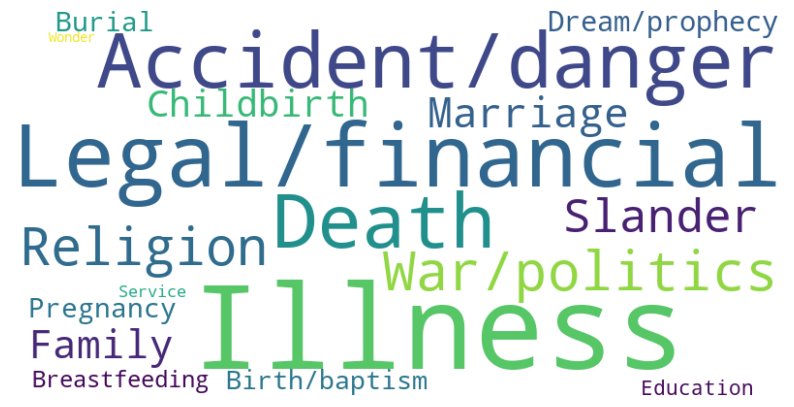

In [343]:
# What is the most common category of event?
from wordcloud import WordCloud

cloud_text = " ".join(event_df['cat'].dropna())
cloud_words = cloud_text.split()
cloud_words_count = Counter(cloud_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(cloud_words_count)
most_common_category = cloud_words_count.most_common(1)[0][0]
most_common_count = cloud_words_count.most_common(1)[0][1]

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes

display(Markdown("### **What is the most common category of event?**"))
print(f'{most_common_category} is the most common category with {most_common_count} events ({(most_common_count / row_count) * 100:.0f}%).')

In [344]:
# How many of the events have different precision or certainty? (e.g. precise/uncertain to the day, month, span of years etc.)

# Count dates in each EDTF class
class_counts = event_df['date_edtf'].apply(lambda x: type(x).__name__).value_counts()

# Get some explanations for the different EDTF class types
with open('edtf-class-info.json', 'r') as file:
    edtf_info = json.load(file)

class_counts_df = class_counts.rename_axis('date_edtf').reset_index(name='count')
class_counts_df['explanation'] = class_counts_df['date_edtf'].map(edtf_info)

display(Markdown("### **How many of the events have different precision or certainty?**"))
display(class_counts_df.style.set_properties(subset=['explanation'], **{'width': '400px', 'text-align': 'left'}))


### **How many of the events have different precision or certainty?**

,date_edtf,count,explanation
0,Date,205,A precise calendar date (e.g. '1979-08-02').
1,UncertainOrApproximate,62,"A date that is either uncertain or approximate or both, indicated with a question mark (?), tilde (~) or percentage (%), respectively (e.g. '1979-08-28~')."
2,Interval,34,A range of dates from one specific date to another (e.g. '1979-08-28/1979-09-25').
3,Level1Interval,16,A date interval where one or both dates may be uncertain or approximate (e.g. '1984-06-02?/2004-08-08~').


In [345]:
# What is the earliest date for an event? (using strict_lower)
earliest_date_index = event_df['date_edtf_lower_strict'].idxmin()
earliest_date_row = event_df.loc[earliest_date_index]
display(Markdown("### **What is the earliest date for an event?**"))
print(f"The earliest date is {earliest_date_row['date_edtf_lower_strict'].strftime('%-d %B, %Y')}, which was {earliest_date_row['title']}.")

### **What is the earliest date for an event?**

The earliest date is 5 January, 1593, which was Birth/baptism: Birth of Alice Wandesford, Thornton's mother.


In [346]:
# What is the latest date? (using strict_upper)
latest_date_index = event_df['date_edtf_upper_strict'].idxmax()
latest_date_row = event_df.loc[latest_date_index]
display(Markdown("### **What is the latest date for an event?**"))
print(f"The latest date is {latest_date_row['date_edtf_lower_strict'].strftime('%-d %B, %Y')}, which was {latest_date_row['title']}.")

### **What is the latest date for an event?**

The latest date is 1 October, 1688, which was Legal/financial: Abstrupus Danby did not fully repay Thornton's costs for his family.


### **Which year has the most events?**

1668 has the most events recorded.


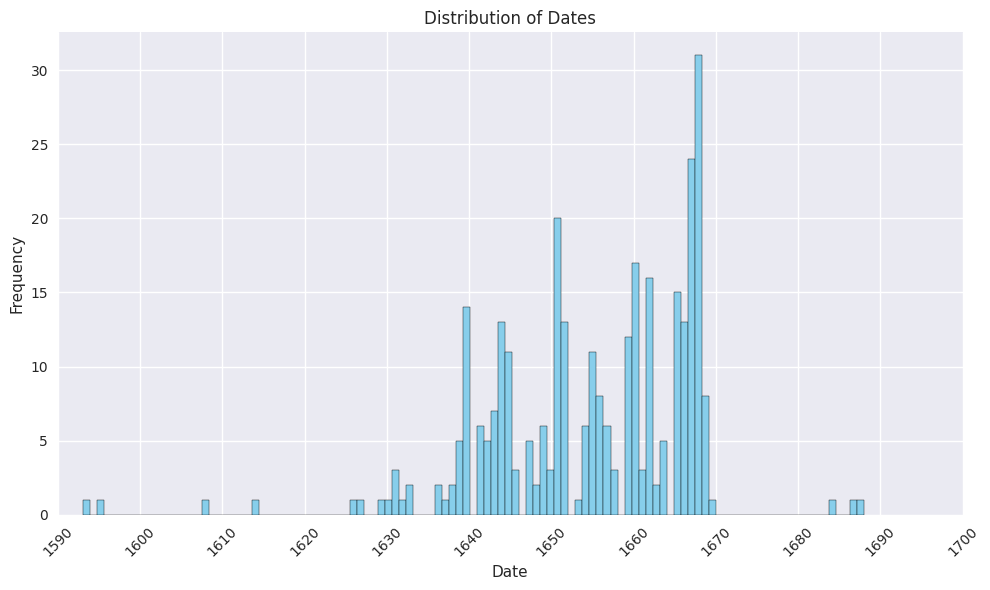

In [347]:
# Which year has the most events?

start_year = 1590  # year of Alice Thornton's birth is 1626; first recorded event is 1593
end_year = 1700 # year of Alice Thornton's death is 1707; no events recorded after 1688

# Extract the year from each date
event_df['date_edtf_lower_strict_year'] = event_df['date_edtf_lower_strict'].apply(lambda date: date.year)

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

plt.hist(event_df['date_edtf_lower_strict_year'], bins=(end_year - start_year + 1), color='skyblue', edgecolor='black')

plt.title('Distribution of Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xlim(start_year, end_year)
plt.xticks(range(start_year, end_year + 1, 10), rotation=45)
plt.tight_layout()

# Get the frequency of each year
year_counts = event_df['date_edtf_lower_strict_year'].value_counts()
year_with_most_events = year_counts.idxmax().max()

display(Markdown("### **Which year has the most events?**"))
print(f"{year_with_most_events} has the most events recorded.")

In [348]:
# Which decade has the most events?

# Group dates by decade
decade_counts = event_df.groupby((event_df['date_edtf_lower_strict_year'] // 10) * 10).size()

# Find the decade with the most events
decade_with_max_events = decade_counts.idxmax()
max_events_count = decade_counts.max()

display(Markdown("### **Which decade has the most events?**"))
print(f"The decade with the most events is: {int(decade_with_max_events)}s, with {max_events_count} events.")
display(decade_counts)

### **Which decade has the most events?**

The decade with the most events is: 1660s, with 134 events.


date_edtf_lower_strict_year
1590      2
1600      1
1610      1
1620      3
1630     17
1640     72
1650     83
1660    134
1670      1
1680      3
dtype: int64

### **How does this correspond to Alice Thornton's age at the time?**

Age 42 has the most events recorded.


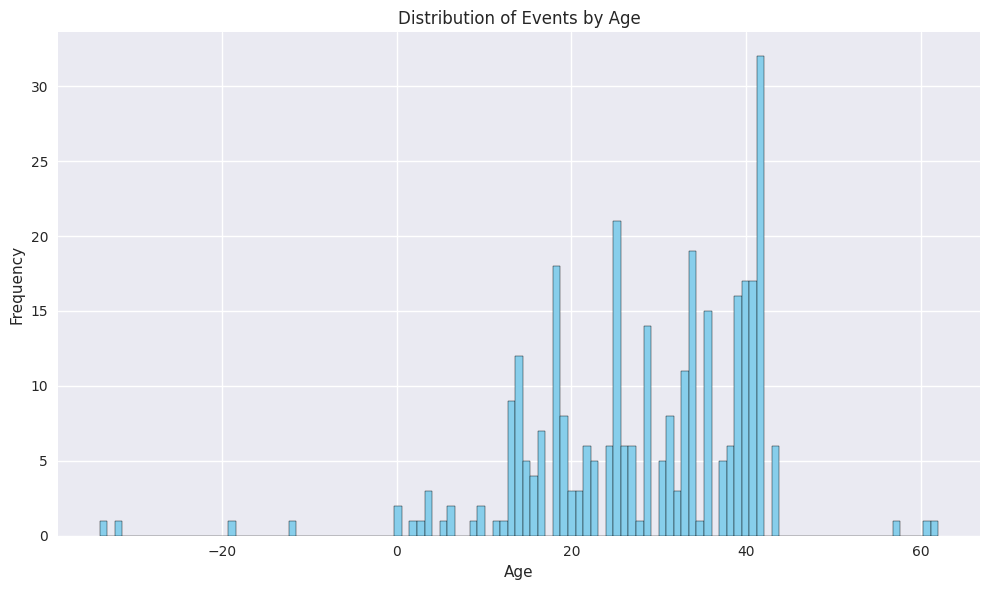

In [349]:
# How does this correspond to Alice Thornton's age at the time?

plt.figure(figsize=(10, 6))

plt.hist(event_df['age_at_date_edtf_lower_strict'], bins=(end_year - start_year + 1), color='skyblue', edgecolor='black')

plt.title('Distribution of Events by Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()

# Get the frequency of each year
age_counts = event_df['age_at_date_edtf_lower_strict'].value_counts()
age_with_most_events = age_counts.idxmax().max()

display(Markdown("### **How does this correspond to Alice Thornton's age at the time?**"))
print(f"Age {age_with_most_events} has the most events recorded.")


In [350]:
# Which decade of her life has the most events?

# Group dates by decade of life
age_decade_counts = event_df.groupby((event_df['age_at_date_edtf_lower_strict'] // 10) * 10).size()

# Find the decade of life with the most events
age_decade_with_max_events = age_decade_counts.idxmax()
age_max_events_count = age_decade_counts.max()

display(Markdown("### **Which decade of her life has the most events?**"))
print(f"The decade of her life with the most events is: {int(age_decade_with_max_events)}s, with {age_max_events_count} events.")
display(age_decade_counts)

### **Which decade of her life has the most events?**

The decade of her life with the most events is: 30s, with 89 events.


age_at_date_edtf_lower_strict
-40     2
-20     2
 0     11
 10    67
 20    71
 30    89
 40    72
 50     1
 60     2
dtype: int64

### **What is the distribution of events recorded over the phases of her life?**

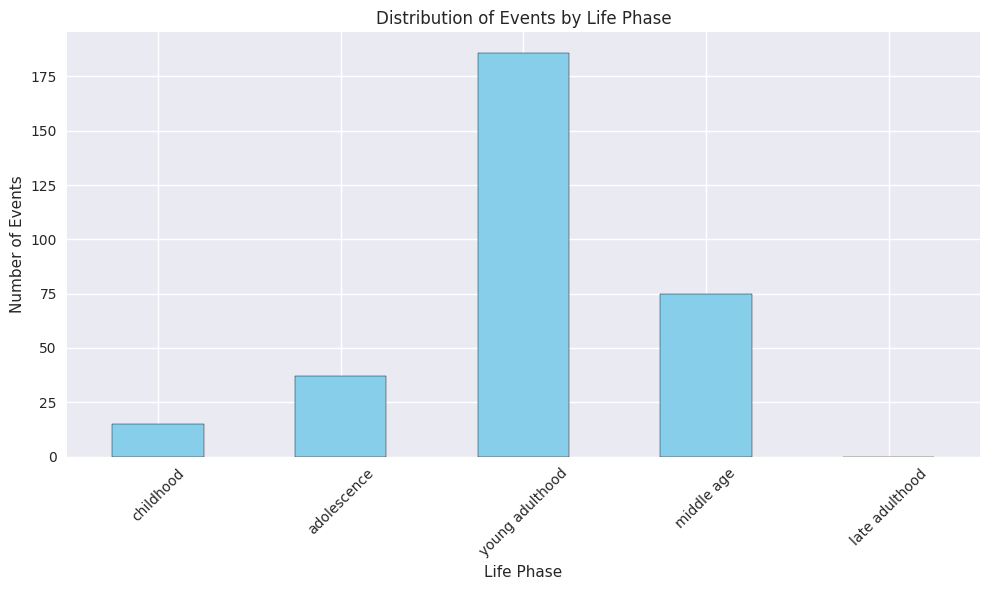

In [351]:
# What is the distribution of events recorded over the phases of her life?

# Create some life phases and corresponding dates. Almost certainly an historian would take issue with these, but it's a start!
age_categories = {
    "childhood": (0, 12),
    "adolescence": (13, 17),
    "young adulthood": (18, 39),
    "middle age": (40, 64),
    "late adulthood": (65, float('inf'))
}

# Function to map ages to categories
def categorise_age(age):
    for category, (lower, upper) in age_categories.items():
        if lower <= age <= upper:
            return category
    return None

# Apply the categorisation function to the age column
event_df['age_category'] = event_df['age_at_date_edtf_lower_strict'].apply(categorise_age)
age_category_counts = event_df['age_category'].value_counts()

# Reorder the counts to match the order of age_categories
ordered_age_category_counts = age_category_counts.reindex(age_categories.keys(), fill_value=0)

plt.figure(figsize=(10, 6))
ordered_age_category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Life Phase')
plt.ylabel('Number of Events')
plt.title('Distribution of Events by Life Phase')
plt.xticks(rotation=45)
plt.tight_layout()

display(Markdown("### **What is the distribution of events recorded over the phases of her life?**"))

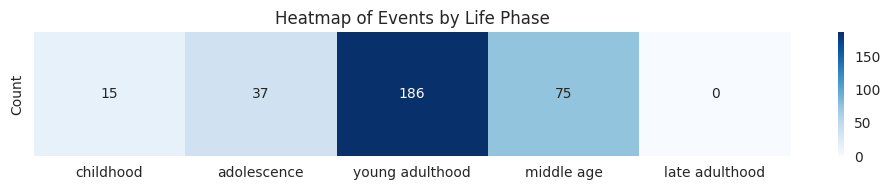

In [352]:
# Bar charts are dull. Is there anything more interesting to do with this data?

import seaborn as sns

# Create a count of each category
heatmap_data = ordered_age_category_counts.values.reshape(1, -1)

# Plot a heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", xticklabels=age_categories.keys(), yticklabels=['Count'])
plt.title('Heatmap of Events by Life Phase')
plt.tight_layout()
